# Spoken Arabic digits perceptron analysis

This notebook contains code to reproduce the results obtained for the real dataset studied in "Covariance based information processing in reservoir computing systems" (https://doi.org/10.1101/2021.04.30.441789). To reproduce the figures presented in the paper (Fig 6 a-b, Fig 9), this code has to be adapted to run multiple times across the reservoir model space (size, leak rate, spectral radius, random seed). However, we only display results for a single reservoir configuration, to reduce computation time. Note that here we do not tune the regularization parameter when using the mean-based readout.

To reproduce results for the synthetic datasets, the same code can be used, making the corresponding changes in input data.

In [1]:
# import libraries

import numpy as np
from perceptron_models import Perceptron
from esn_models import SequentialReservoir
import auxiliary_functions as af 
import time
import os
import readout_optimizers as ropt
import pickle
import matplotlib.pyplot as plt

In [2]:
# load digits train data and zero pad it
my_dir = os.getcwd()
digits_train, train_labels = af.preprocess_train_data(my_dir+'/dataset/SpokenArabicDigits_TRAIN.arff', d=50)

# **Working without a reservoir**

We will first train mean and covariance perceptron (Perceptron class from `perceptron_models.py`)  readouts directly on inputs.

In the next cell, we train the covariance perceptron using custom code.

In [3]:
### Create model ######

# Initialize model
inSize = 13
outSize = 10 # number classes
initLen = 0
trainLen = 50
non_linear = False
random_state = 42  #[42, 33, 78, 0, 91, 59, 47, 44, 40, 63] loop over this list to get results from paper
epochs = 100 # fixed
lr = 0.01 # fixed
batch_size = 32 # fixed, we can optimize it through cv grid search on training set, not done here to reduce code execution time 

model = Perceptron(inSize=inSize, outSize=outSize, non_linear=False, random_state=random_state)
optimizer = ropt.GradientDescent(params=model.Wout, batch_size=batch_size, lr=lr, num_classes=10)
X_train = digits_train
y_train = train_labels

# train
loss = []
np.random.seed(0) 
train_scores = []
start_time = time.perf_counter()
for epoch in range(1, epochs + 1):
    # batch data, shuffle
    index = np.random.choice(X_train.shape[0], size=X_train.shape[0], replace=False)
    X_ = X_train[index, :, :]  # shuffled data
    y_ = y_train[index]  # shuffled data
    epochLoss = []
    for (batchX, batchY) in af.next_batch(X_, y_, batch_size):
        Qerror = optimizer.get_loss(batchX, batchY)
        epochLoss.append(np.sum(Qerror ** 2) / batchX.shape[0])
        delta = optimizer.get_gradients(batchX, Qerror)
        optimizer.update_params(delta)

    loss.append(np.mean(epochLoss))

    model.Wout = optimizer.params
    model.run(X_train, initLen=initLen, trainLen=trainLen, covariance=True)
    # score
    y_pred = model.predict(mode='covariance')
    score = model.score(y_train, y_pred)
    train_scores.append(score)
    print(f'Epoch {epoch} / {epochs} finished')

end_time = time.perf_counter()
print(f'Training took {end_time - start_time} seconds')
    



Epoch 1 / 100 finished
Epoch 2 / 100 finished
Epoch 3 / 100 finished
Epoch 4 / 100 finished
Epoch 5 / 100 finished
Epoch 6 / 100 finished
Epoch 7 / 100 finished
Epoch 8 / 100 finished
Epoch 9 / 100 finished
Epoch 10 / 100 finished
Epoch 11 / 100 finished
Epoch 12 / 100 finished
Epoch 13 / 100 finished
Epoch 14 / 100 finished
Epoch 15 / 100 finished
Epoch 16 / 100 finished
Epoch 17 / 100 finished
Epoch 18 / 100 finished
Epoch 19 / 100 finished
Epoch 20 / 100 finished
Epoch 21 / 100 finished
Epoch 22 / 100 finished
Epoch 23 / 100 finished
Epoch 24 / 100 finished
Epoch 25 / 100 finished
Epoch 26 / 100 finished
Epoch 27 / 100 finished
Epoch 28 / 100 finished
Epoch 29 / 100 finished
Epoch 30 / 100 finished
Epoch 31 / 100 finished
Epoch 32 / 100 finished
Epoch 33 / 100 finished
Epoch 34 / 100 finished
Epoch 35 / 100 finished
Epoch 36 / 100 finished
Epoch 37 / 100 finished
Epoch 38 / 100 finished
Epoch 39 / 100 finished
Epoch 40 / 100 finished
Epoch 41 / 100 finished
Epoch 42 / 100 finished
E

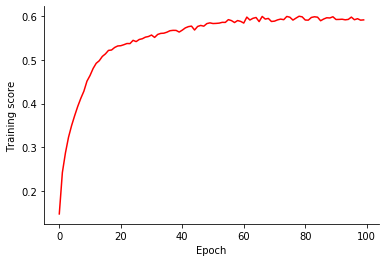

In [4]:
# plot training score (or loss, up to you)
plt.plot(np.arange(len(train_scores)), train_scores, color='r')
plt.xlabel('Epoch')
plt.ylabel('Training score')
plt.show()

In [5]:
# now we get test performance for our covariance perceptron model
# load test data
digits_test, test_labels = af.preprocess_test_data(my_dir+'/dataset/SpokenArabicDigits_TEST.arff', d=50)


In [6]:
# get test score
model.run(digits_test, initLen=initLen, trainLen=trainLen, covariance=True)
y_pred = model.predict(mode='covariance')
score = model.score(test_labels, y_pred)
print(f'Test score of final covariance perceptron model is {100*score}')

Test score of final covariance perceptron model is 59.79990904956799


Now we will train an example of mean-based perceptron model

In [7]:
mean_model = Perceptron(inSize=inSize, outSize=outSize, non_linear=False, random_state=random_state)
# train mean model
optimizer = ropt.RidgeReg(params=mean_model.Wout, batch_size=None, solver='auto', alpha=0.1, fit_intercept=True,
                          num_classes=10)

optimizer.fit(X=X_train, y=y_train.tolist())

# update parameters and save readout
model.Wout = optimizer.params

model.run(X_train, initLen=initLen, trainLen=trainLen, mean=True)

# score
y_pred = model.predict(mode='mean')
print(f'Training score is {100*mean_model.score(train_labels, y_pred)}')

# test score
mean_model.run(digits_test, initLen=initLen, trainLen=trainLen, mean=True)
y_pred = mean_model.predict(mode='mean')
print(f'Test score is {100*mean_model.score(test_labels, y_pred)}')

Training score is 60.93347476890438
Test score is 58.29922692132787


# Working with a reservoir

When using a reservoir in the pipeline, we simply do a "preprocessing step" where we feed the digit inputs, collect the reservoir states and afterwards use this data to train a covariance or a mean perceptron readout. As example, we will use a single reservoir of size N=50, leak=0.2 and radius = 1.2. Again, results to get figures must be ran multiple times across reservoir space parameters initialized with different random seeds. Importantly, we did not optimize the batch size for learning here, as done for the previous covariance perceptron readouts. 

In [8]:
# create reservoir
inSize = 13 # input dimension
resSize = 50 #reservoir size
outsize=10 # classes
leak = 0.2
radius = 1.2
random_state = 42
initLen =  0 # collect states from beginning, no washout transient
trainLen = 50 # this is parameter d in the paper
reservoir = SequentialReservoir(inSize=inSize, resSize=resSize, outSize=outSize, leak=leak, radius=radius, random_state=random_state)

# collect states
time_start = time.perf_counter()
reservoir.run(digits_train, initLen=initLen, trainLen=trainLen)
train_states = reservoir.resStates
time_end = time.perf_counter()
print(f'Collecting reservoir states took {time_end-time_start} seconds')

In [9]:
# Now train covariance model

# optimizer parameters
epochs = 25 # use 100 to get paper results
batch_size = 1 # not optimized
lr = 0.01

optimizer = ropt.GradientDescent(params=reservoir.Wout, batch_size=batch_size,
                                lr=lr, num_classes=10)

loss = []
start_time = time.perf_counter()
for epoch in range(1, epochs + 1):
    # batch data, shuffle
    index = np.random.choice(train_states.shape[0], size=train_states.shape[0], replace=False)
    X_ = train_states[index, :, :]  # shuffled data
    y_ = train_labels[index]  # shuffled data
    epochLoss = []
    for (batchX, batchY) in af.next_batch(X_, y_, batch_size):
        Qerror = optimizer.get_loss(batchX, batchY)
        epochLoss.append(np.sum(Qerror**2)/batchX.shape[0])
        delta = optimizer.get_gradients(batchX, Qerror)
        optimizer.update_params(delta)

    loss.append(np.mean(epochLoss))
    reservoir.Wout = optimizer.params
    print(f'Epoch {epoch} / {epochs} finished')

end_time = time.perf_counter()
print(f'Training took {end_time - start_time} seconds')

# update parameters
reservoir.resStates = train_states
reservoir.update_outputs(initLen=initLen, trainLen=trainLen, covariance=True)
# score
y_pred = reservoir.predict(mode='covariance')
score = reservoir.score(train_labels, y_pred)
print(f'Training score is {100*score}')

Epoch 1 / 25 finished
Epoch 2 / 25 finished
Epoch 3 / 25 finished
Epoch 4 / 25 finished
Epoch 5 / 25 finished
Epoch 6 / 25 finished
Epoch 7 / 25 finished
Epoch 8 / 25 finished
Epoch 9 / 25 finished
Epoch 10 / 25 finished
Epoch 11 / 25 finished
Epoch 12 / 25 finished
Epoch 13 / 25 finished
Epoch 14 / 25 finished
Epoch 15 / 25 finished
Epoch 16 / 25 finished
Epoch 17 / 25 finished
Epoch 18 / 25 finished
Epoch 19 / 25 finished
Epoch 20 / 25 finished
Epoch 21 / 25 finished
Epoch 22 / 25 finished
Epoch 23 / 25 finished
Epoch 24 / 25 finished
Epoch 25 / 25 finished
Training took 990.6178782 seconds
Training score is 90.01363843006516


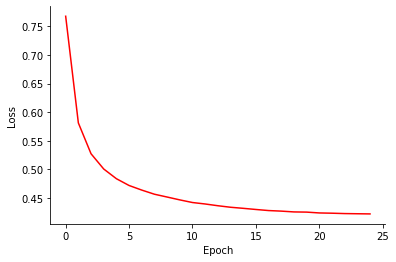

In [10]:
# plot training loss
plt.plot(np.arange(len(loss)), loss, color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [11]:
# get test score

reservoir.run(digits_test, initLen=initLen, trainLen=trainLen)
reservoir.update_outputs(initLen=initLen, trainLen=trainLen, covariance=True)
# score
y_pred = reservoir.predict(mode='covariance')
score=reservoir.score(test_labels, y_pred)
print(f'Test acore is {100*score}')

Test acore is 92.54206457480673


We will now get the digit recognition accuracy when coupling the reservoir to a mean-based perceptron readout

In [12]:
# we will create a new reservoir so it starts from same conditions as previous one
inSize = 13 # input dimension
resSize = 50 #reservoir size
outsize=10 # classes
leak = 0.2
radius = 1.2
random_state = 42
initLen =  0 # collect states from beginning, no washout transient
trainLen = 50 # this is parameter d in the paper
reservoir_2 = SequentialReservoir(inSize=inSize, resSize=resSize, outSize=outSize, leak=leak, radius=radius, random_state=random_state)

# collect states
time_start = time.perf_counter()
reservoir_2.run(digits_train, initLen=initLen, trainLen=trainLen)
train_states = reservoir_2.resStates
time_end = time.perf_counter()
print(f'Collecting reservoir states took {time_end-time_start} seconds')


In [13]:
# train mean model
optimizer = ropt.RidgeReg(params=reservoir_2.Wout, batch_size=None, solver='auto', alpha=0.1, fit_intercept=True, num_classes=10)
optimizer.fit(X=train_states, y=train_labels.tolist())

# update parameters and save readout
reservoir_2.Wout = optimizer.params
reservoir_2.update_outputs(initLen=initLen, trainLen=trainLen, mean=True)

# score
y_pred = reservoir_2.predict(mode='mean')
print(f'Training score is {100*reservoir_2.score(train_labels, y_pred)}')
                

Training score is 86.86164570389452


In [15]:
# get test score

reservoir_2.run(digits_test, initLen=initLen, trainLen=trainLen)
reservoir_2.update_outputs(initLen=initLen, trainLen=trainLen, mean=True)

#score
y_pred = reservoir_2.predict(mode='mean')
print(f'Test score is {100*reservoir_2.score(test_labels, y_pred)}')


Test score is 86.31195998180992
